<h1 align="center"><b>Route Finding</h1>

https://latlong.info/india/andhra-pradesh 

you can find all the cities of andrapradesh cities latitude and longtitudes here . copy them and paste them in a csv file .. we didnt have already available datasets for the coty to city distances . so we need to calculate the distances between the cities using thier locations .

In [15]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

# Load the dataset
df = pd.read_csv('andra cities.csv')

# Clean the city names
df['city/town'] = df['city/town'].str.replace(' Latitude and Longitude', '')


In [16]:
df

city/town       lat       lon
0           Addanki  15.81061  79.97338
1             Adoni  15.62788  77.27495
2       Akasahebpet  17.50455  82.56597
3           Akividu  16.58225  81.38112
4      Akkarampalle  13.65000  79.42000
..              ...       ...       ...
163         Vuyyuru  16.36307  80.84406
164   West Godavari  17.00000  81.16667
165           Yanam  16.73308  82.21364
166  Yanamalakuduru  16.48531  80.66746
167          Yarada  17.65872  83.27419

[168 rows x 3 columns]

Using harvesine formula we can calculate distances between the two locations . 

In [17]:

# Define the Haversine formula to calculate distance between two lat-lon pairs
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat / 2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Create a list to store the distances
distances = []

# Calculate distances between each pair of cities
for i in range(len(df)):
    for j in range(i + 1, len(df)):
        city1 = df.iloc[i]['city/town']
        city2 = df.iloc[j]['city/town']
        lat1, lon1 = df.iloc[i]['lat'], df.iloc[i]['lon']
        lat2, lon2 = df.iloc[j]['lat'], df.iloc[j]['lon']
        distance = haversine(lat1, lon1, lat2, lon2)
        distances.append([city1, city2, distance])

# Create a DataFrame from the distances
distances_df = pd.DataFrame(distances, columns=['Starting City', 'Destination City', 'Distance (km)'])

# Save the distances to a CSV file
distances_df.to_csv('andhra_pradesh_city_distances.csv', index=False)

print("Dataset created and saved as 'andhra_pradesh_city_distances.csv'")


Dataset created and saved as 'andhra_pradesh_city_distances.csv'


In [18]:
data=pd.read_csv('andhra_pradesh_city_distances.csv')

In [19]:
data

Starting City Destination City  Distance (km)
0             Addanki            Adoni     289.541733
1             Addanki      Akasahebpet     334.288244
2             Addanki          Akividu     173.083554
3             Addanki     Akkarampalle     247.508648
4             Addanki       Amalapuram     233.253306
...               ...              ...            ...
14023   West Godavari   Yanamalakuduru      78.108660
14024   West Godavari           Yarada     235.391512
14025           Yanam   Yanamalakuduru     167.041121
14026           Yanam           Yarada     152.593988
14027  Yanamalakuduru           Yarada     306.259340

[14028 rows x 3 columns]

Above data contains the distance between all the available cities . It is not reccomended cause we can face issues like this :

Below is the network of connections of all these cities .
imagine you want to go from a to z and our data contains the distances between a to b , a to c and ...... a to z also . so our data directly says you can go from a to z but not a to b to c .. to z .

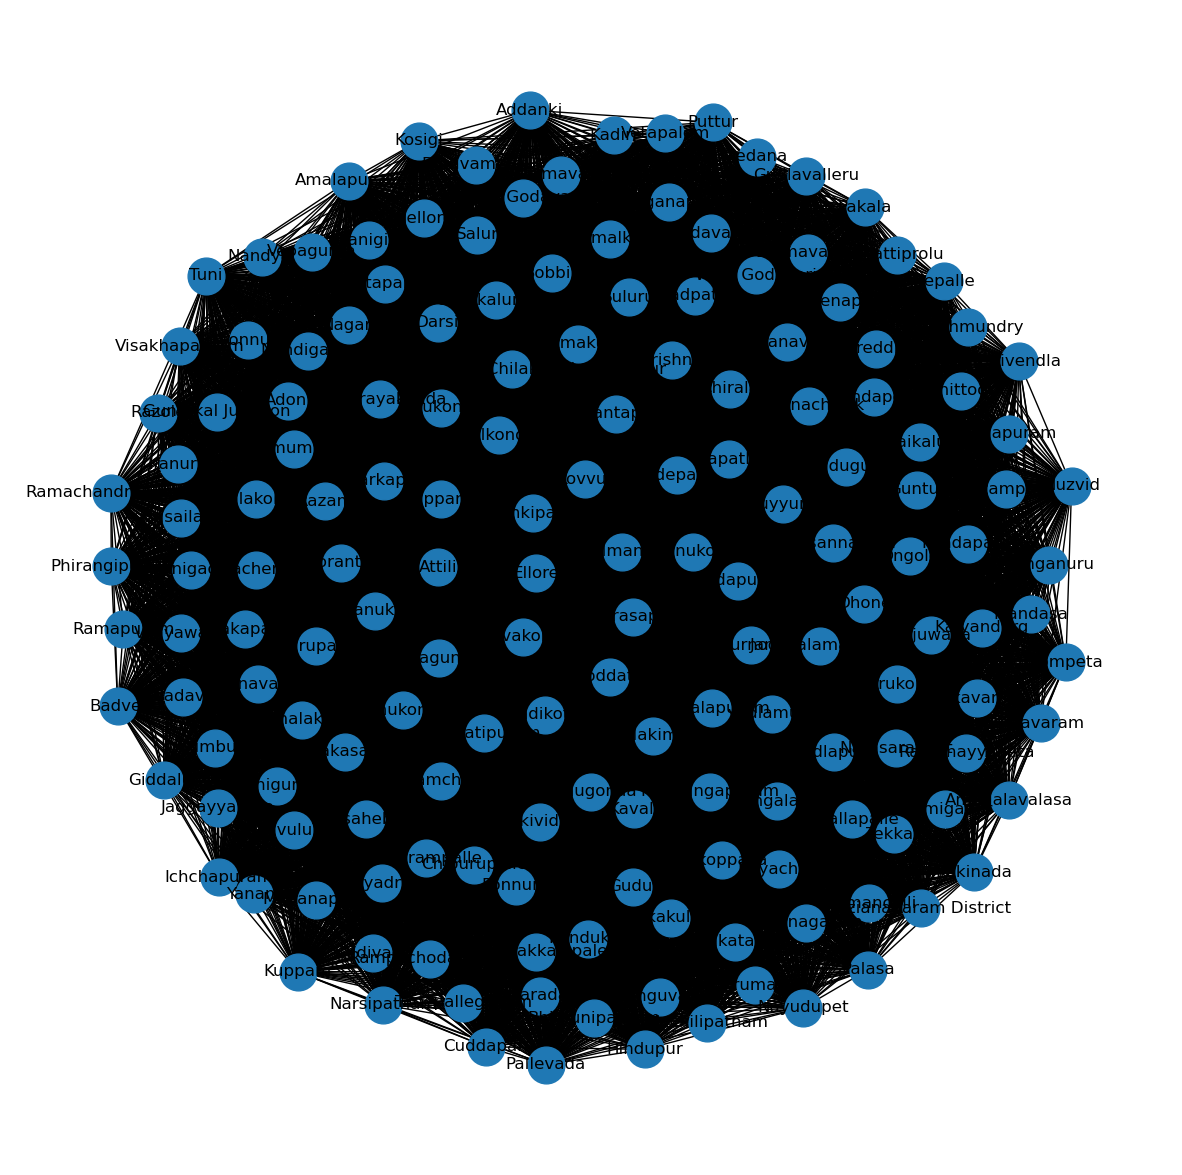

[('Addanki', 167),
 ('Adoni', 167),
 ('Akasahebpet', 167),
 ('Akividu', 167),
 ('Akkarampalle', 167),
 ('Amalapuram', 167),
 ('Amudalavalasa', 167),
 ('Anakapalle', 167),
 ('Anantapur', 167),
 ('Atmakur', 167)]

In [89]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a graph from the dataframe
G = nx.from_pandas_edgelist(data, 'Starting City', 'Destination City', ['Distance (km)'])

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G, k=0.15, seed=42)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=700)

# edges
nx.draw_networkx_edges(G, pos, width=1)

# labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

plt.axis('off')
plt.show()

# Identify the cities with the most connections
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# Show top 10 cities with the most connections
sorted_degree[:10]

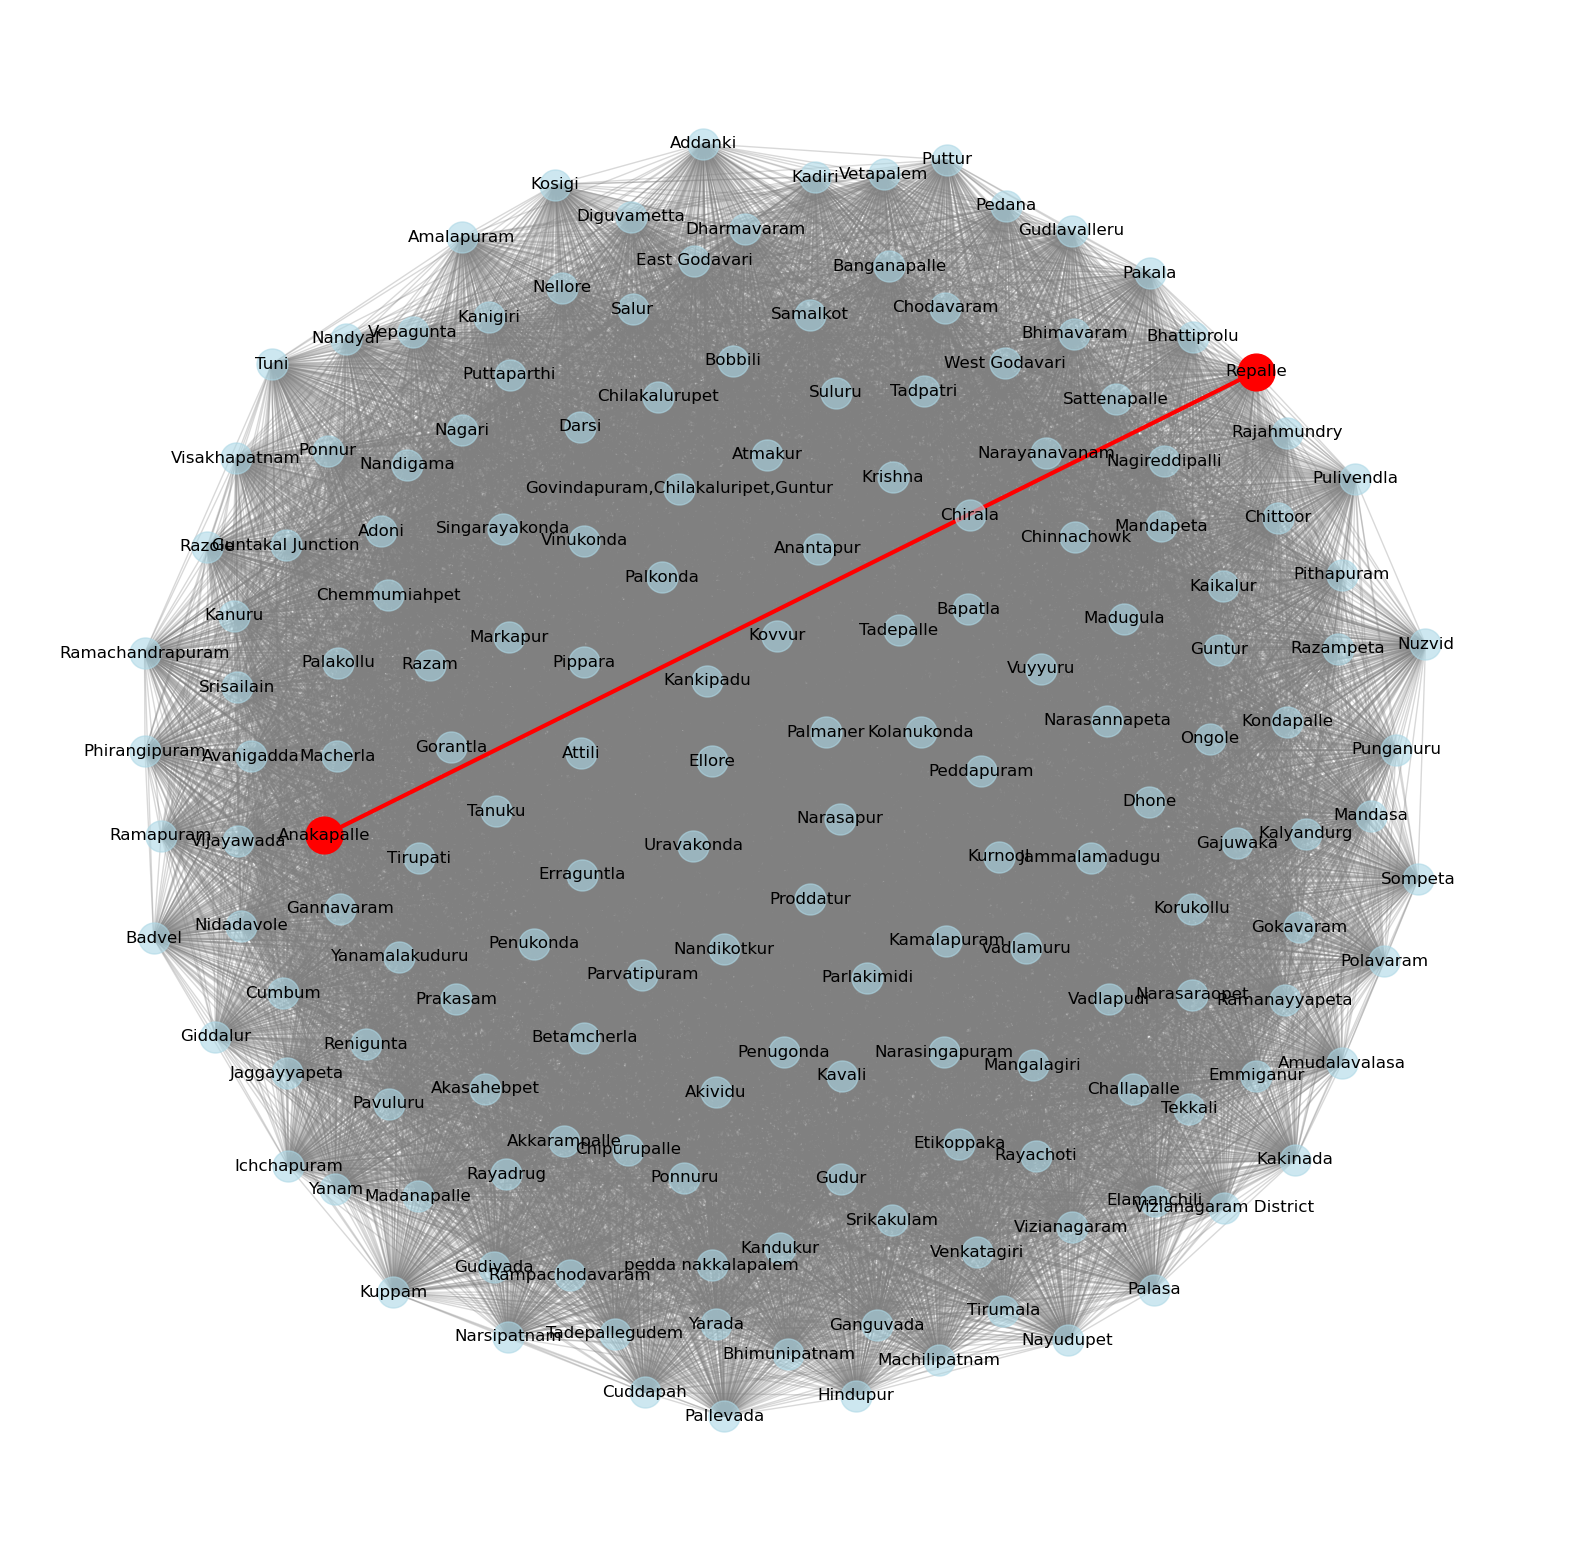

['Repalle', 'Anakapalle']

In [90]:
# Calculate the shortest path based on distance
try:
    shortest_path = nx.shortest_path(G, source='Repalle', target='Anakapalle', weight='Distance')

    # Visualization
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.15, seed=42)

    # Draw all nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=12)

    # Draw the shortest path
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color='red', node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

    plt.axis('off')
    plt.show()

    # Return the shortest path
    shortest_path
except nx.NetworkXNoPath:
    shortest_path = "No path found"
except nx.NodeNotFound:
    shortest_path = "One of the nodes not found in the graph"

shortest_path

we need to modify this data and take only shortest distances between the cities . here we need to consider that finding shortest distances may gives you bunch of pairs :

ex: if a-b have small distance then b-a also have small distance so it wont find another city . so we choose the algorithm to find second smallest distance from the first destination city ..

in this way following dataset is created .
remember the following dataset is not efficiently created cause it may ignore some cities distances cause they're greater . 

ex: if we have chosen a to c instead of a to b because c has lesser distance . and later when were about to find the smallest distances we may encounter a to c to .. some other cities . instead of a to b . while total distance from a to b you have is may be lesser than the shorest distance your data is predicted ..

# This data is only for demonstrating Finding routes and understanding the networks .

In [40]:
df = pd.read_csv('andhra_pradesh_city_distances.csv')

# Ensure column names are appropriate
df.columns = ['Starting City', 'Destination City', 'Distance (km)']

# Create a new DataFrame to store the minimum distances
result_df = pd.DataFrame(columns=['Starting City', 'Destination City', 'Distance (km)'])

# Iterate over each city
for city in df['Starting City'].unique():
    # Filter the DataFrame to get distances from the current city
    city_df = df[df['Starting City'] == city]
    # Find the closest neighboring city
    min_distance_row = city_df.loc[city_df['Distance (km)'].idxmin()]
    # Add the minimum distance to the result DataFrame
    result_df = pd.concat([result_df, pd.DataFrame([min_distance_row])], ignore_index=True)

# Save the result to a new CSV file
result_df.to_csv('min_distances_between_cities.csv', index=False)

# Print the result
print(result_df)


             Starting City Destination City  Distance (km)
0                  Addanki         Pavuluru      20.998509
1                    Adoni           Kosigi      25.473243
2              Akasahebpet             Tuni      16.316021
3                  Akividu        Pallevada       9.230065
4             Akkarampalle         Tirupati       1.611258
..                     ...              ...            ...
162  Vizianagaram District           Yarada      84.352121
163                Vuyyuru   Yanamalakuduru      23.227993
164          West Godavari   Yanamalakuduru      78.108660
165                  Yanam           Yarada     152.593988
166         Yanamalakuduru           Yarada     306.259340

[167 rows x 3 columns]


In [1]:
import pandas as pd
result_df=pd.read_csv('min_distances_between_cities.csv')

In [2]:
result_df

Starting City Destination City  Distance (km)
0                  Addanki         Pavuluru      20.998509
1                    Adoni           Kosigi      25.473243
2              Akasahebpet             Tuni      16.316021
3                  Akividu        Pallevada       9.230065
4             Akkarampalle         Tirupati       1.611258
..                     ...              ...            ...
162  Vizianagaram District           Yarada      84.352121
163                Vuyyuru   Yanamalakuduru      23.227993
164          West Godavari   Yanamalakuduru      78.108660
165                  Yanam           Yarada     152.593988
166         Yanamalakuduru           Yarada     306.259340

[167 rows x 3 columns]

For better visualizations and understanding please consider using min_distances.csv file and for accurate data use andrapradesh_city_distances.csv and filter it to have distances less than 200 km which gives us the better and accurate results which will very similar to the realtime distances of cities in AndraPradesh

![image.png](attachment:image.png)
![image-2.png](attachment:image-2.png)
![image-3.png](attachment:image-3.png)

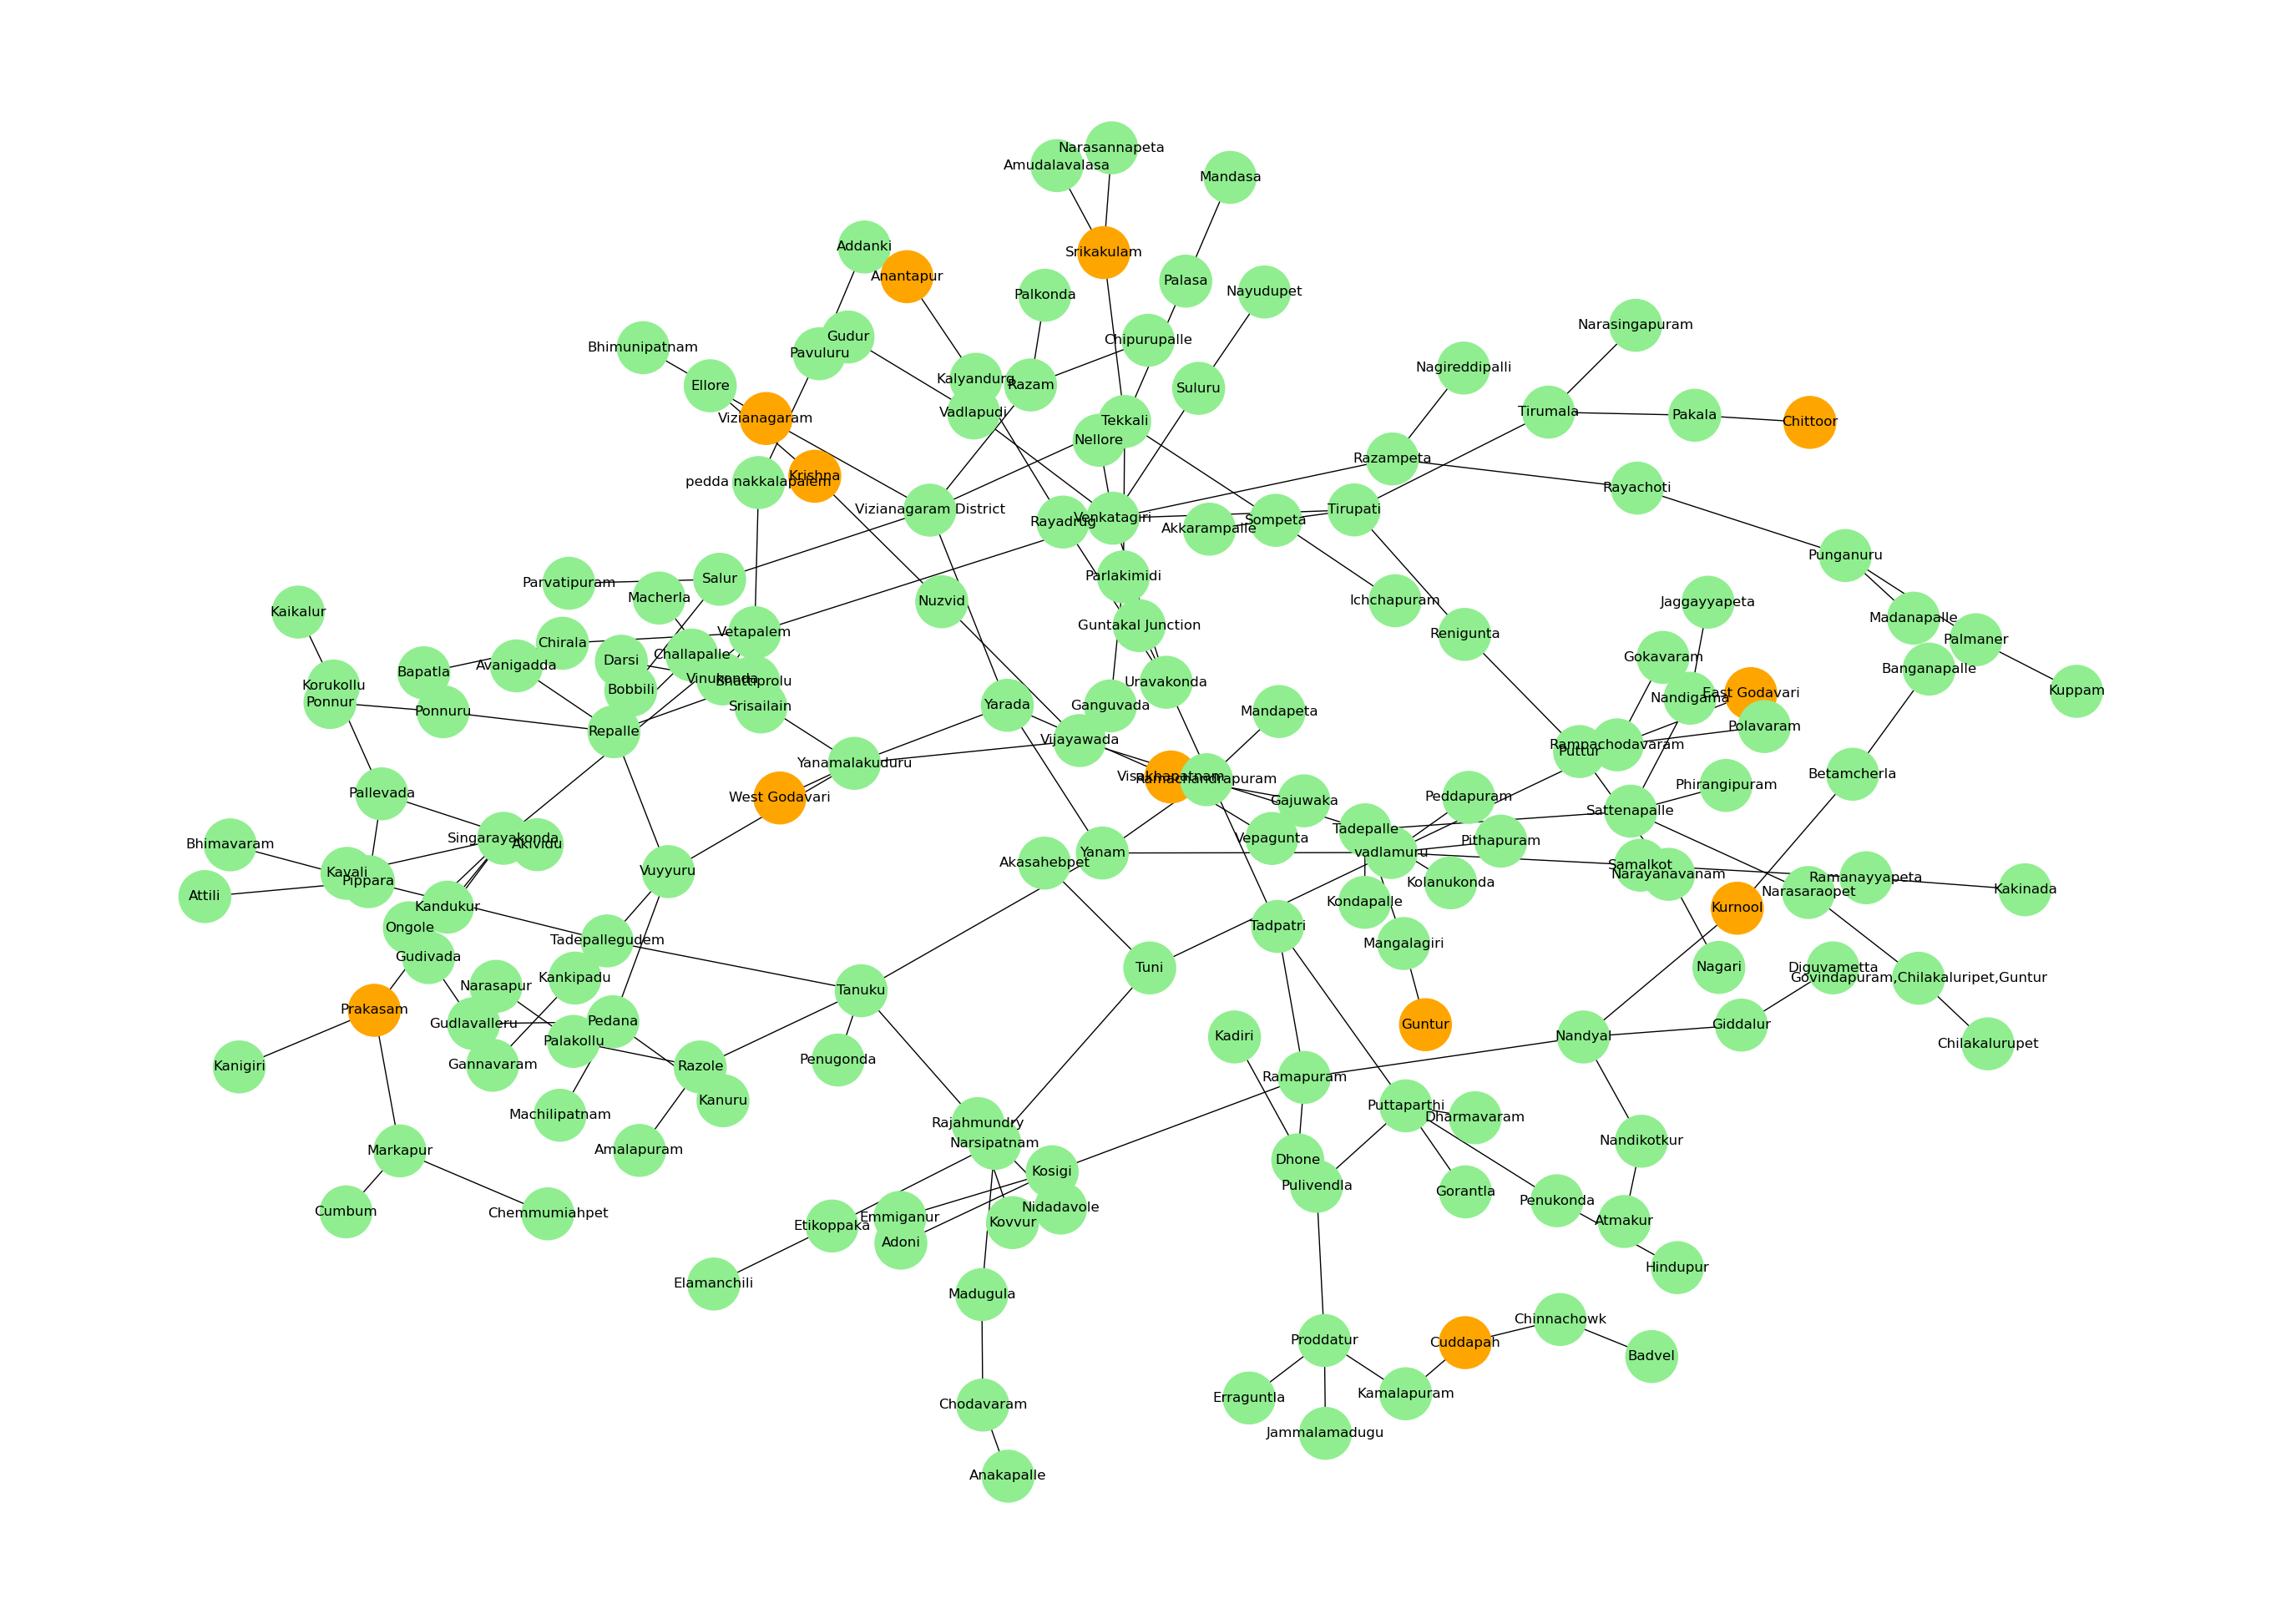

[('Venkatagiri', 7),
 ('vadlamuru', 6),
 ('Repalle', 5),
 ('Vetapalem', 5),
 ('Vinukonda', 5),
 ('Puttaparthi', 5),
 ('Singarayakonda', 5),
 ('Tadepalle', 5),
 ('Tekkali', 5),
 ('Tanuku', 5)]

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# List of cities to be colored in light orange
orange_cities = [
    'Anantapur', 'Chittoor', 'East Godavari', 'Guntur', 'Krishna', 'Kurnool',
    'Prakasam', 'Srikakulam', 'Sri Potti Sriramulu Nellore', 'Visakhapatnam',
    'Vizianagaram', 'West Godavari', 'Cuddapah'
]

# Create a graph from the dataframe
G = nx.from_pandas_edgelist(result_df, 'Starting City', 'Destination City', ['Distance (km)'])

# Draw the graph
plt.figure(figsize=(35, 25))
pos = nx.spring_layout(G, k=0.15, seed=42)  # smaller k value for increased spacing

# Create a list of colors for each node
node_colors = ['orange' if node in orange_cities else 'lightgreen' for node in G.nodes()]

# Draw nodes with different colors and adjust node size to avoid overlap
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)

# Draw edges
nx.draw_networkx_edges(G, pos, width=1)

# Draw node labels with black color and adjust label positions
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif', font_color='black')

plt.axis('off')
plt.show()

# Identify the cities with the most connections
degree_dict = dict(G.degree(G.nodes()))
sorted_degree = sorted(degree_dict.items(), key=lambda item: item[1], reverse=True)

# Show top 10 cities with the most connections
sorted_degree[:10]


Here we shown the cities on this graph and also found the number of connections we have for each of the city .ex: venkatagiri has 7 cities that connected to it . 
- orange cities are the districts and green cities are the normal cities 

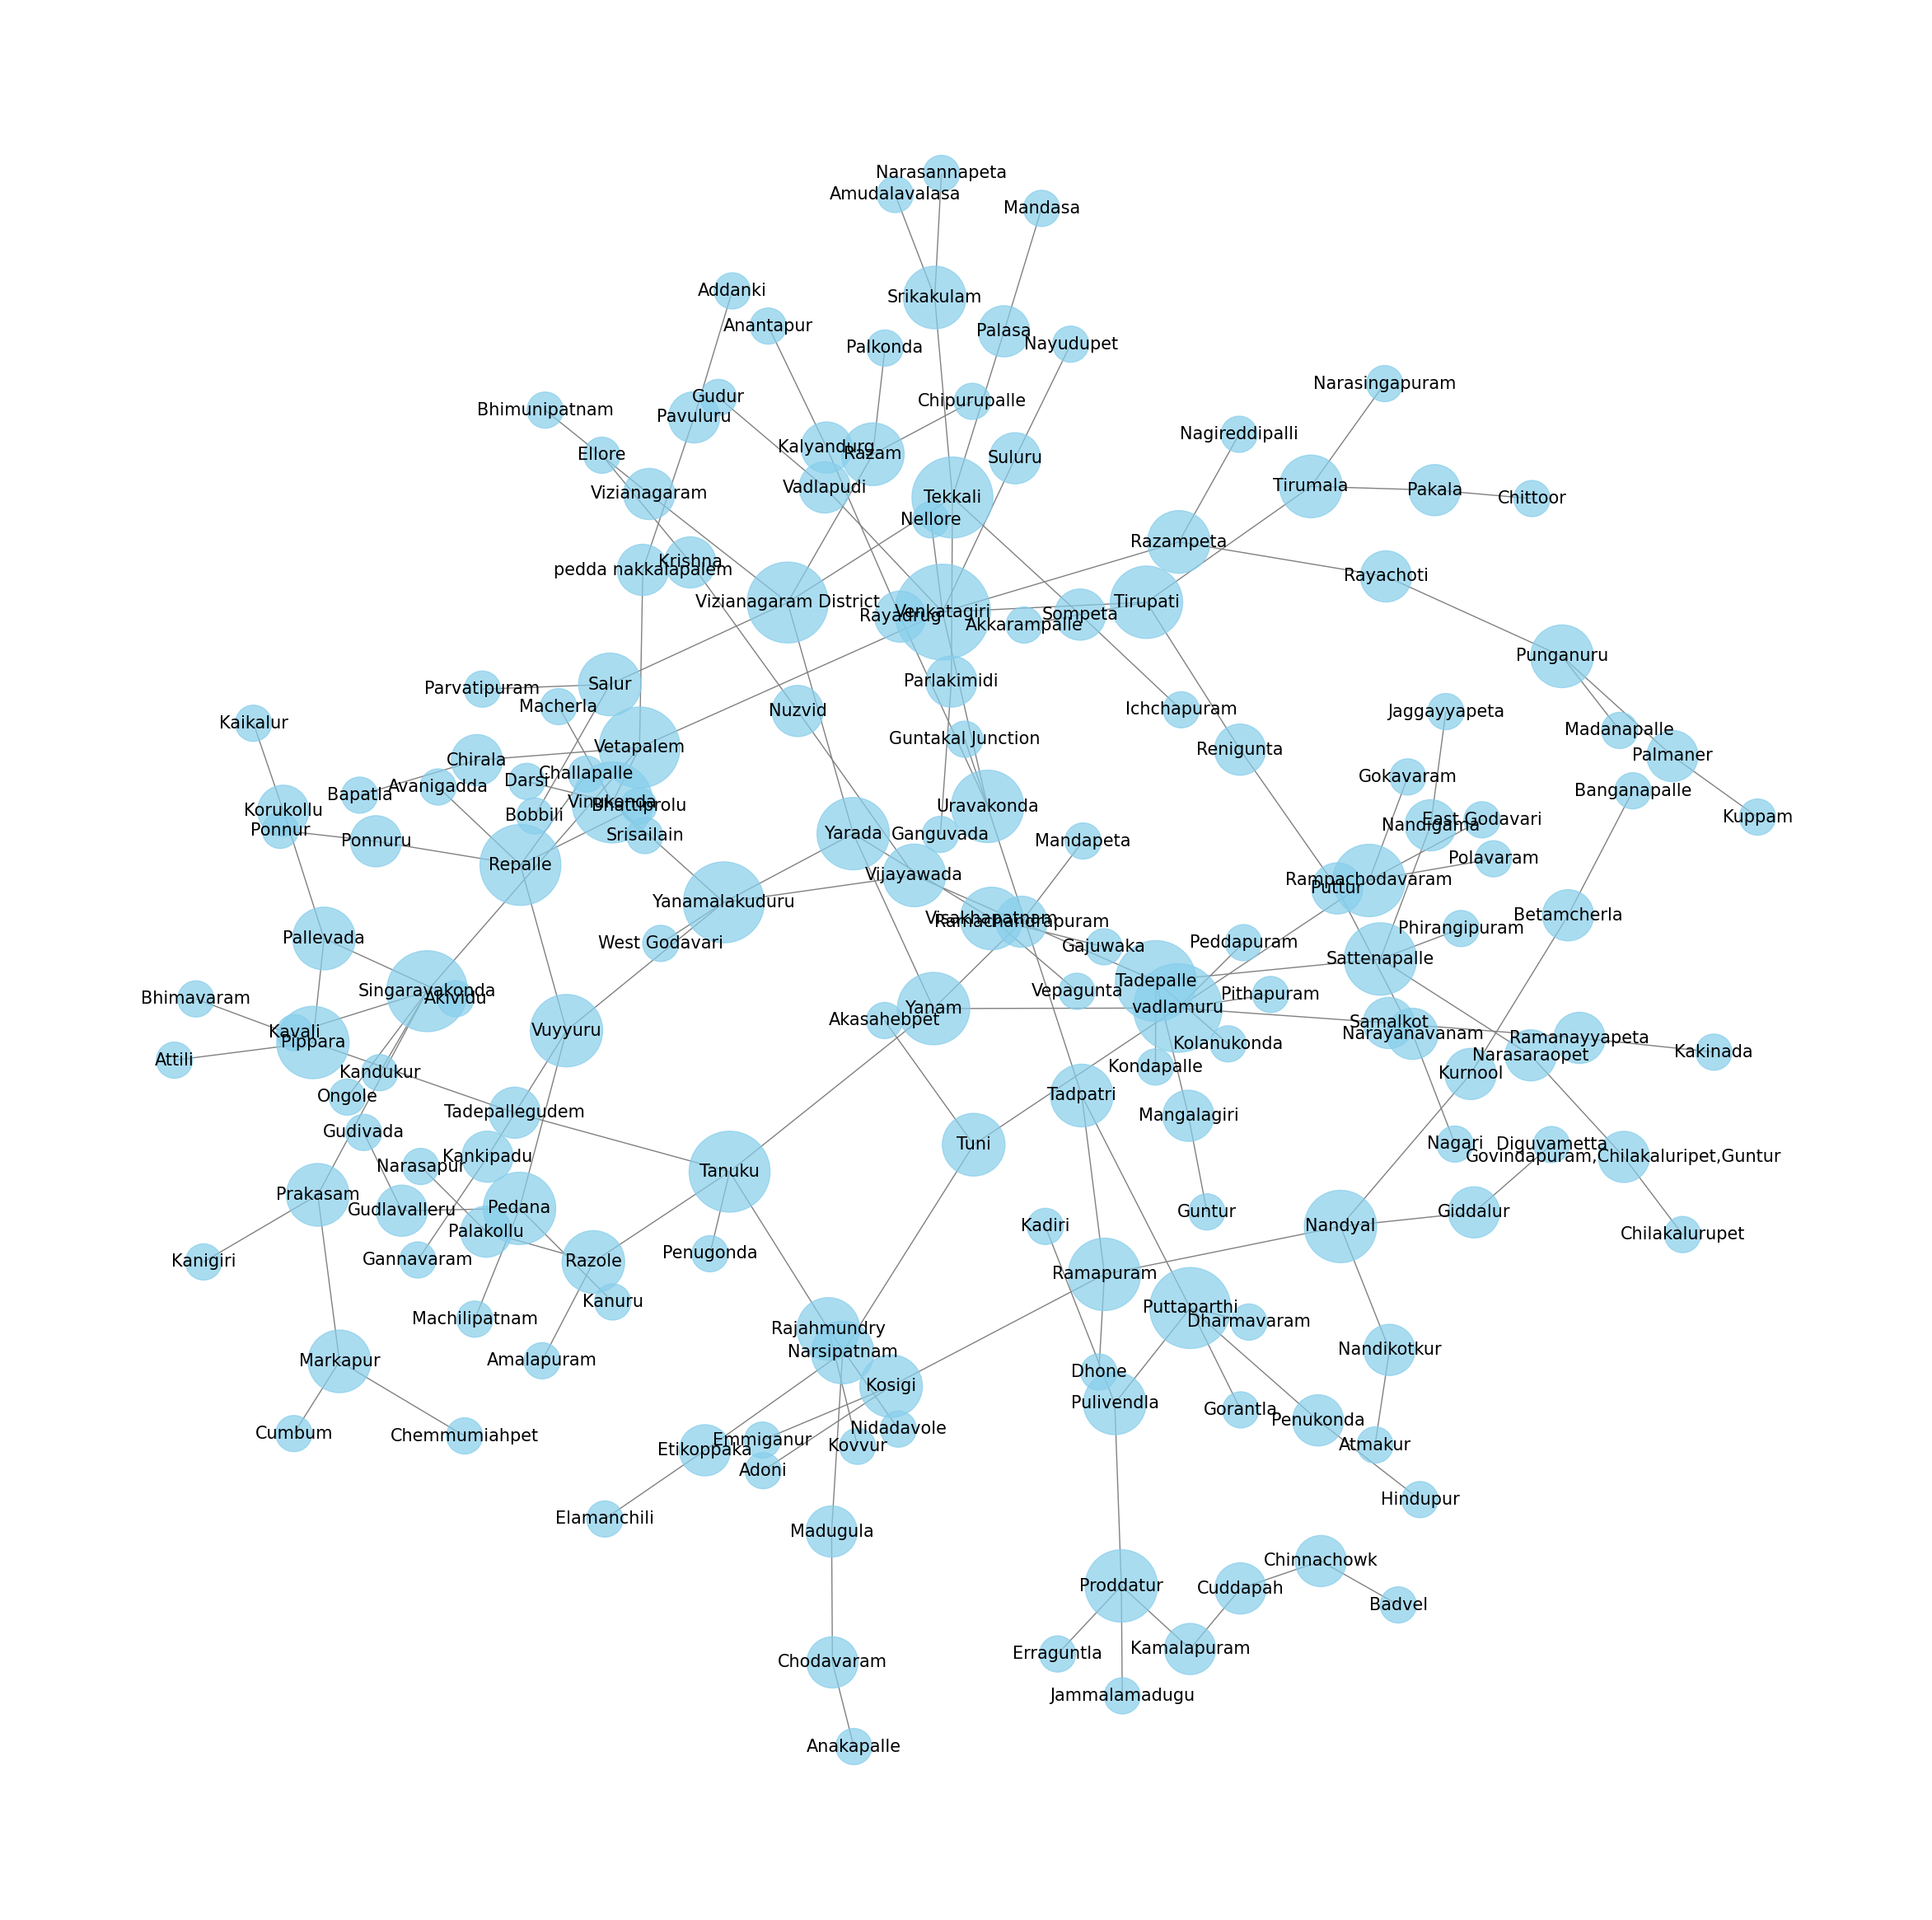

In [78]:
# Draw the graph with node size corresponding to the number of connections (degree)

# Determine node size by the number of connections, scaled
node_sizes = [v * 1000 for v in degree_dict.values()]

plt.figure(figsize=(30, 30))
# Position nodes using Fruchterman-Reingold force-directed algorithm
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='skyblue', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=15)

# Remove the axis
plt.axis('off')

# Show the graph
plt.show()

In [79]:
# we will calculate the betweenness centrality, closeness centrality and eigenvector centrality

# Calculate centrality measures
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

# We will return the top 5 cities for each centrality measure for brevity
top_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
top_closeness = sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True)[:5]
top_eigenvector = sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True)[:5]

# Compile the results into a readable format
analysis_results = {
    "Top Betweenness Centrality": top_betweenness,
    "Top Closeness Centrality": top_closeness,
    "Top Eigenvector Centrality": top_eigenvector,
}

analysis_results

{'Top Betweenness Centrality': [('Yanamalakuduru', 0.6525503210446576),
  ('Vetapalem', 0.5501046100569944),
  ('Yarada', 0.5275954115864656),
  ('Vinukonda', 0.5120842652045307),
  ('Venkatagiri', 0.5085491667267874)],
 'Top Closeness Centrality': [('Yanamalakuduru', 0.20341047503045068),
  ('Vinukonda', 0.19904648390941598),
  ('Vetapalem', 0.1930635838150289),
  ('Yarada', 0.19261822376009227),
  ('Venkatagiri', 0.18132464712269272)],
 'Top Eigenvector Centrality': [('Venkatagiri', 0.4629283190797162),
  ('Vetapalem', 0.37692599508799396),
  ('Vinukonda', 0.26773224474048063),
  ('Uravakonda', 0.2261317741137663),
  ('Yanamalakuduru', 0.22316558497204186)]}

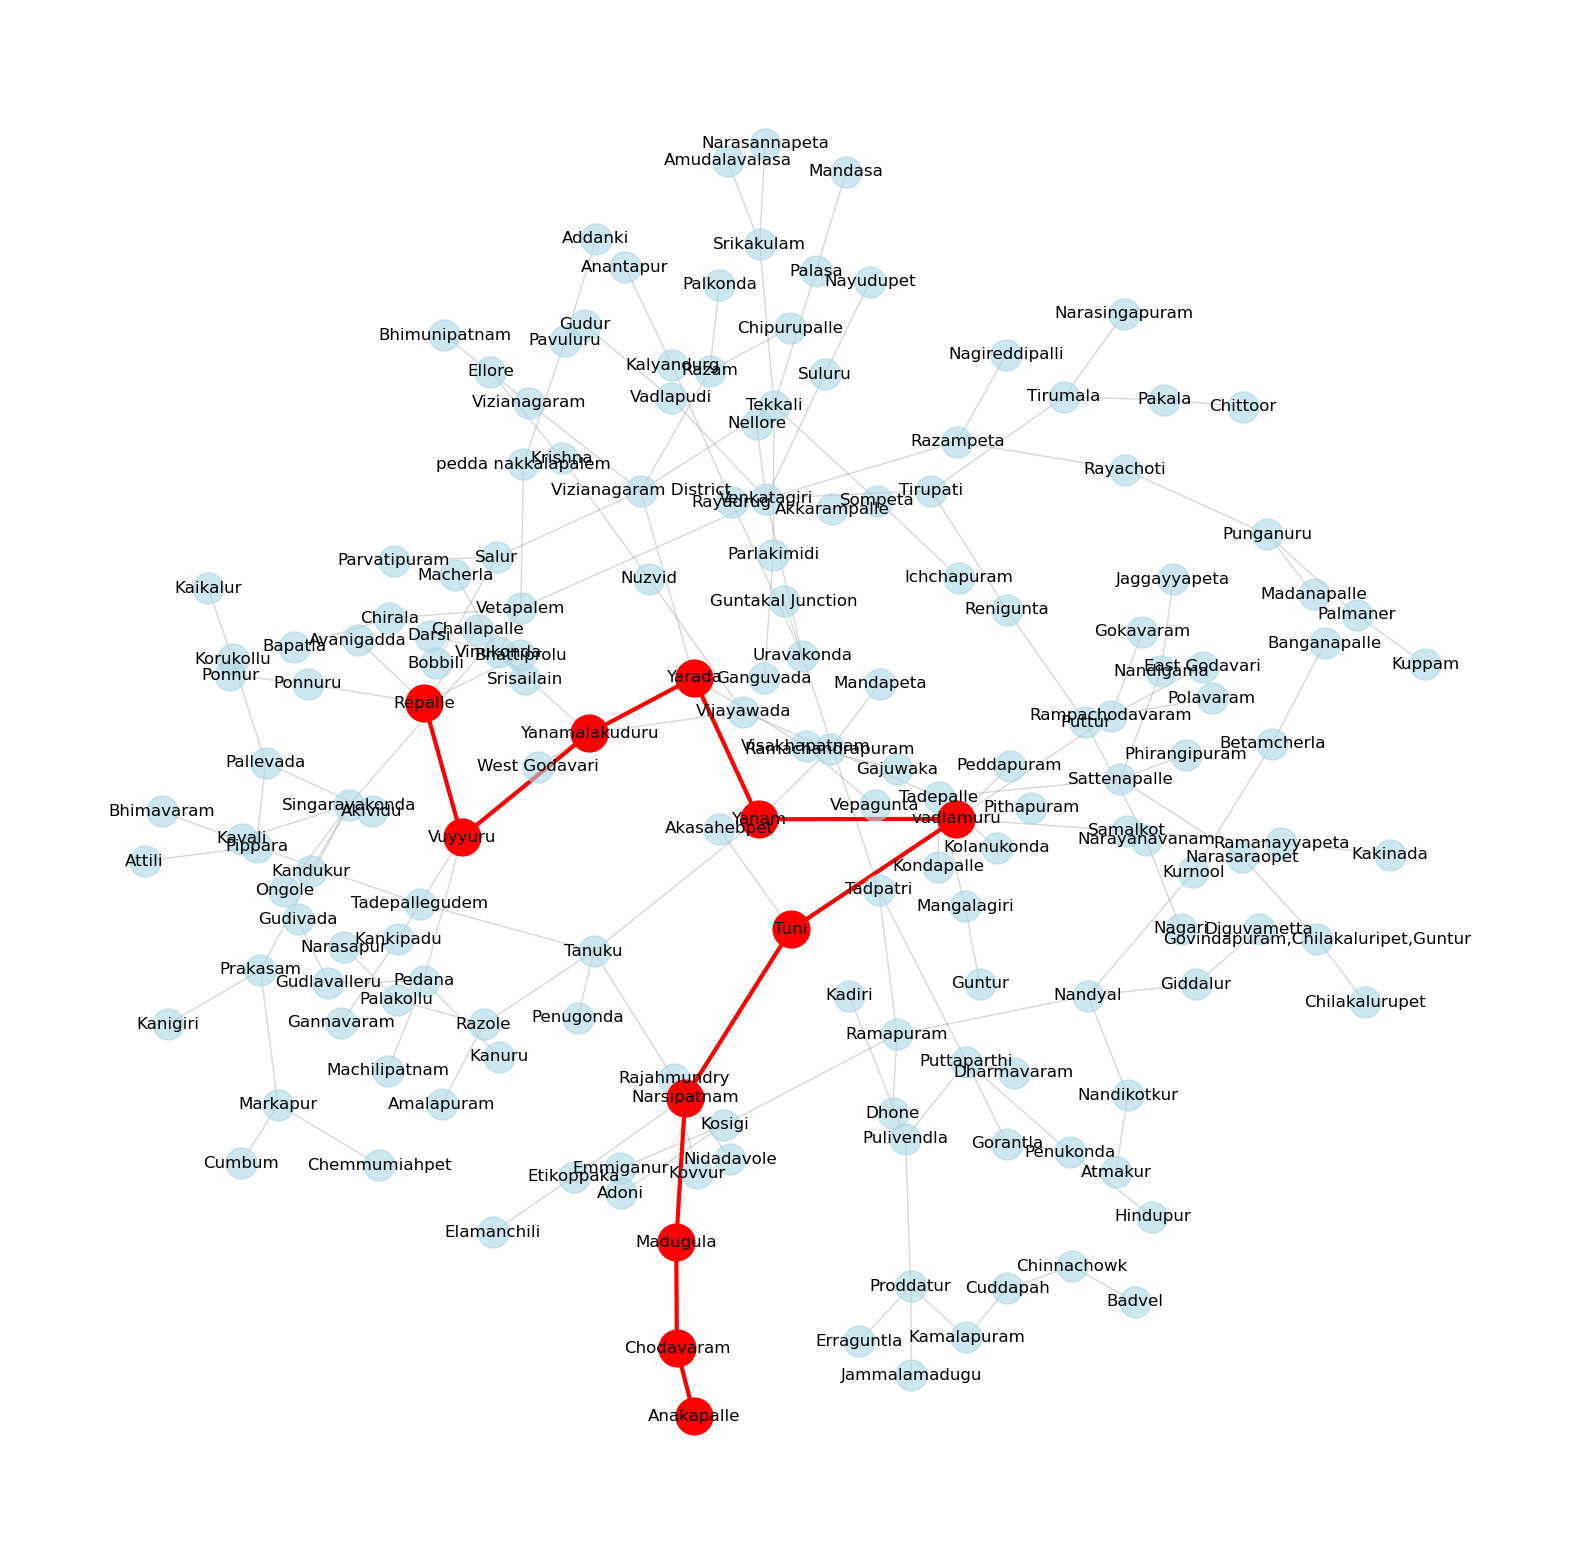

['Repalle',
 'Vuyyuru',
 'Yanamalakuduru',
 'Yarada',
 'Yanam',
 'vadlamuru',
 'Tuni',
 'Narsipatnam',
 'Madugula',
 'Chodavaram',
 'Anakapalle']

In [88]:
# Calculate the shortest path based on distance
try:
    shortest_path = nx.shortest_path(G, source='Repalle', target='Anakapalle', weight='Distance')

    # Visualization
    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.15, seed=42)

    # Draw all nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
    nx.draw_networkx_labels(G, pos, font_size=12)

    # Draw the shortest path
    path_edges = list(zip(shortest_path, shortest_path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color='red', node_size=700)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)

    plt.axis('off')
    plt.show()

    # Return the shortest path
    shortest_path
except nx.NetworkXNoPath:
    shortest_path = "No path found"
except nx.NodeNotFound:
    shortest_path = "One of the nodes not found in the graph"

shortest_path

Here we calculated the shortest path between two cities and found the path 

C:\Users\eswar\AppData\Local\Temp\ipykernel_7040\3220595515.py:27: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, alpha=0.6)


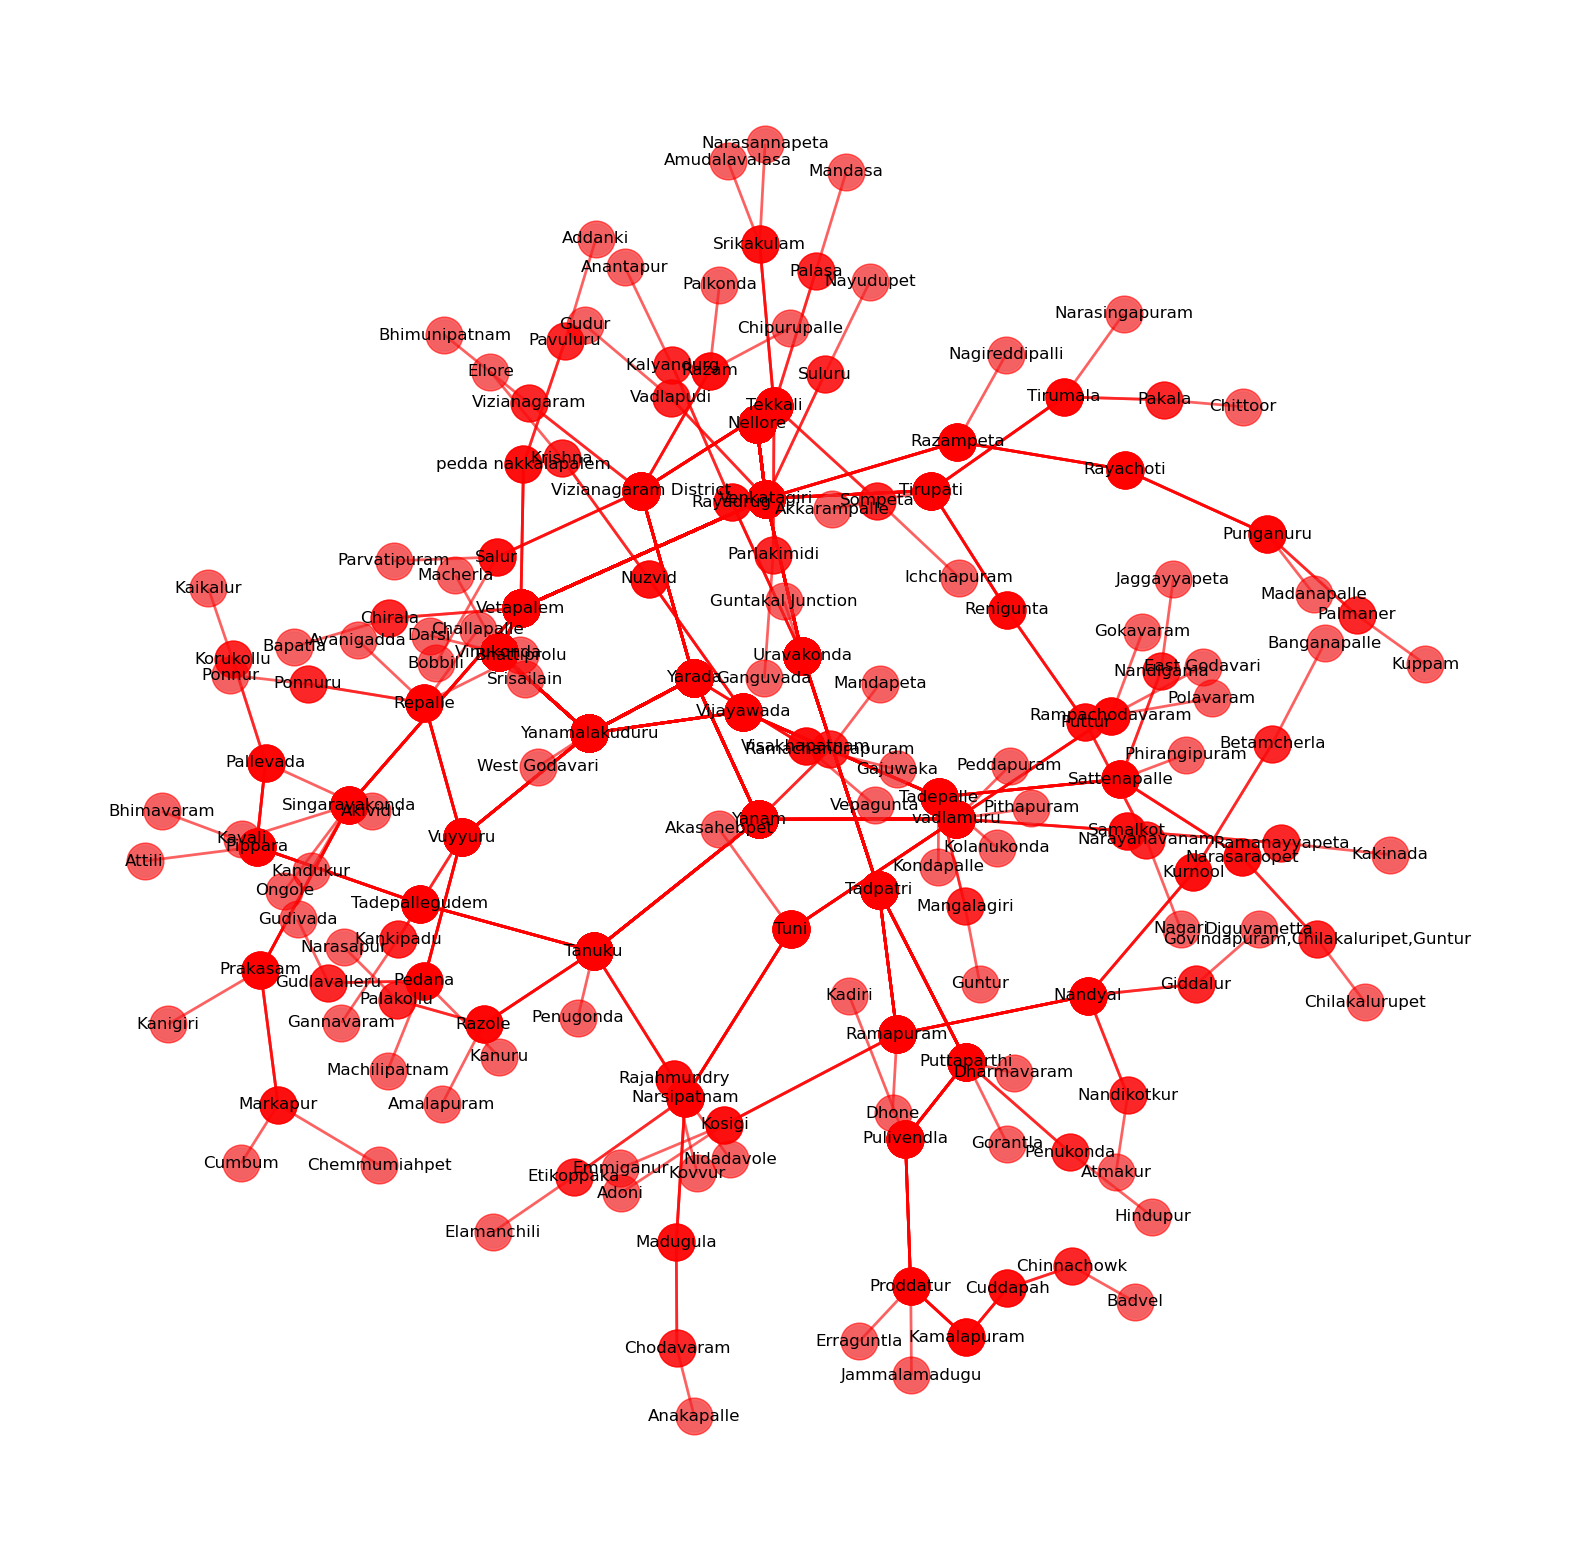

{'Nellore': ['Nellore'],
 'Venkatagiri': ['Nellore', 'Venkatagiri'],
 'Razampeta': ['Nellore', 'Venkatagiri', 'Razampeta'],
 'Suluru': ['Nellore', 'Venkatagiri', 'Suluru'],
 'Tirupati': ['Nellore', 'Venkatagiri', 'Tirupati'],
 'Uravakonda': ['Nellore', 'Venkatagiri', 'Uravakonda'],
 'Vadlapudi': ['Nellore', 'Venkatagiri', 'Vadlapudi'],
 'Vetapalem': ['Nellore', 'Venkatagiri', 'Vetapalem'],
 'Nagireddipalli': ['Nellore', 'Venkatagiri', 'Razampeta', 'Nagireddipalli'],
 'Rayachoti': ['Nellore', 'Venkatagiri', 'Razampeta', 'Rayachoti'],
 'Nayudupet': ['Nellore', 'Venkatagiri', 'Suluru', 'Nayudupet'],
 'Akkarampalle': ['Nellore', 'Venkatagiri', 'Tirupati', 'Akkarampalle'],
 'Renigunta': ['Nellore', 'Venkatagiri', 'Tirupati', 'Renigunta'],
 'Tirumala': ['Nellore', 'Venkatagiri', 'Tirupati', 'Tirumala'],
 'Guntakal Junction': ['Nellore',
  'Venkatagiri',
  'Uravakonda',
  'Guntakal Junction'],
 'Rayadrug': ['Nellore', 'Venkatagiri', 'Uravakonda', 'Rayadrug'],
 'Tadpatri': ['Nellore', 'Venkata

In [87]:
# Compute all pairs shortest paths
all_pairs_shortest_paths = dict(nx.all_pairs_dijkstra_path(G, weight='Distance'))

# Visualization is tricky for all pairs shortest paths since it would clutter the graph significantly.
# Instead, we'll visualize only a subset to keep it readable.

# For the sake of visualization, let's just take a subset (e.g., paths originating from 'Mumbai')
subset_shortest_paths = {source: paths for source, paths in all_pairs_shortest_paths.items() if source == 'Nellore'}

# Visualization
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw all nodes and edges with light colors
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.3)
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.1)
nx.draw_networkx_labels(G, pos, font_size=12)

# Highlight the paths from 'Mumbai' to all other cities
for destination, path in subset_shortest_paths['Nellore'].items():
    path_edges = list(zip(path, path[1:]))
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_color='red', node_size=700, alpha=0.6)
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2, alpha=0.6)

plt.axis('off')
plt.show()

# Return a sample of the all pairs shortest paths (for brevity)
# Here we show the shortest paths originating from 'Mumbai'
subset_shortest_paths['Nellore']

Here we used Dijkstras shortest path to find all the shortest paths from one common city 

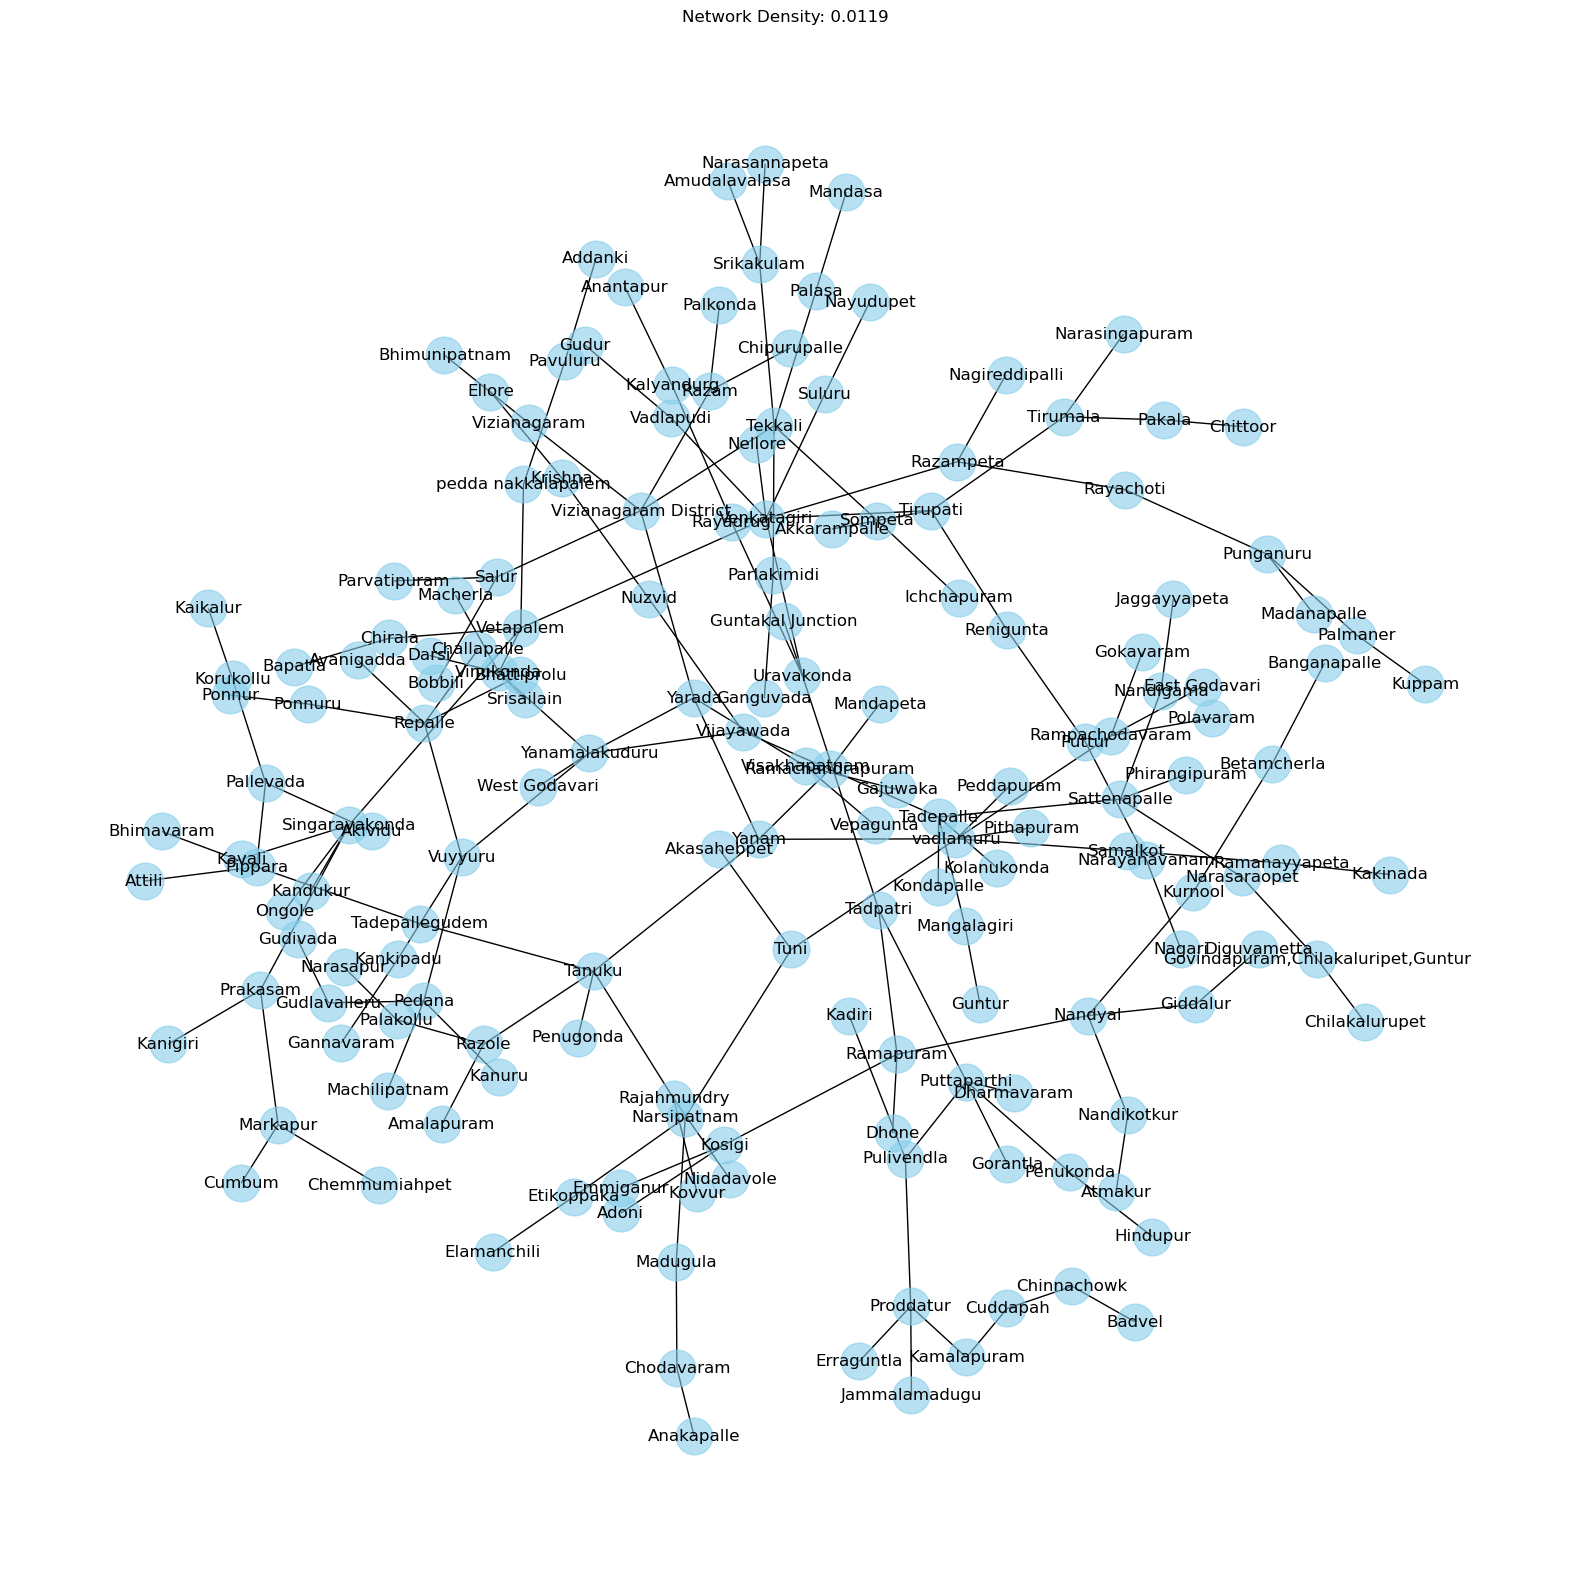

0.011904761904761904

In [93]:
# Network density is a measure of how many edges are in the network compared to how many could possibly exist
# between all pairs of nodes. It gives an idea of how interconnected the network is.

# Calculate network density
network_density = nx.density(G)

# For visualization, we can illustrate the network density by showing the actual edges
# versus the maximum possible number of edges in a complete graph of the same size.

# Visualize the network
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(G, k=0.15, seed=42)

# Draw all nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color="skyblue", alpha=0.6)
# Draw all edges
nx.draw_networkx_edges(G, pos, width=1)

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12)

plt.title(f"Network Density: {network_density:.4f}")
plt.axis('off')
plt.show()

# Return the calculated network density
network_density

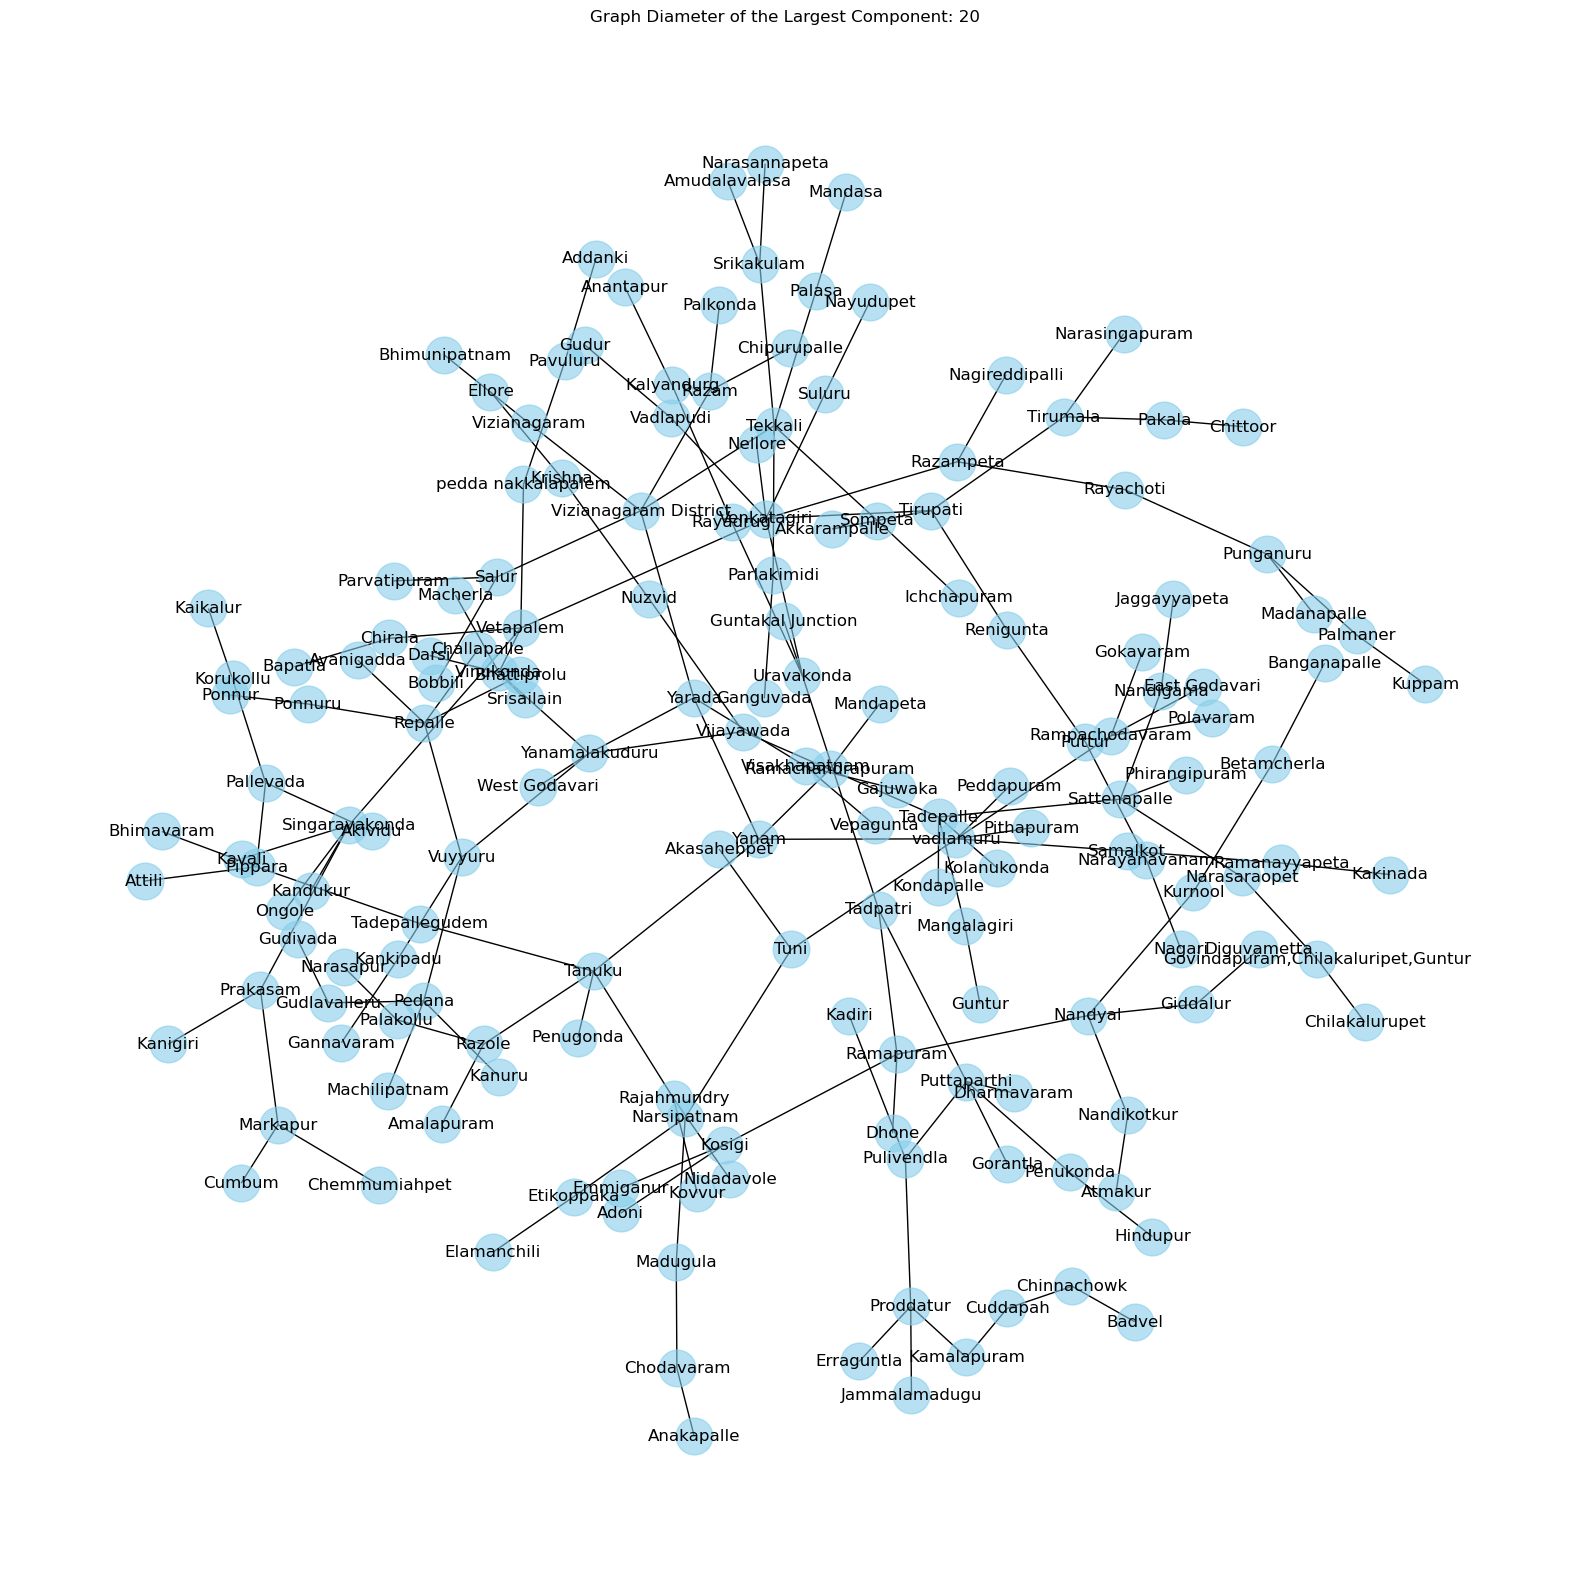

{0: 20}

In [99]:
# To calculate the graph diameter, the graph must be fully connected. If it's not, we can calculate the diameter for each connected component.

# Find connected components
connected_components = list(nx.connected_components(G))

# Initialize the dictionary to store diameters
component_diameters = {}

# Calculate the diameter for each connected component
for i, component_nodes in enumerate(connected_components):
    subgraph = G.subgraph(component_nodes)
    component_diameters[i] = nx.diameter(subgraph)

# Visualization of the largest connected component
largest_component = max(connected_components, key=len)
subgraph = G.subgraph(largest_component)

# Draw the largest connected component
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(subgraph, k=0.15, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(subgraph, pos, width=1)
nx.draw_networkx_labels(subgraph, pos, font_size=12)

plt.title(f"Graph Diameter of the Largest Component: {component_diameters[max(component_diameters, key=component_diameters.get)]}")
plt.axis('off')
plt.show()

# Return the diameters of each connected component
component_diameters

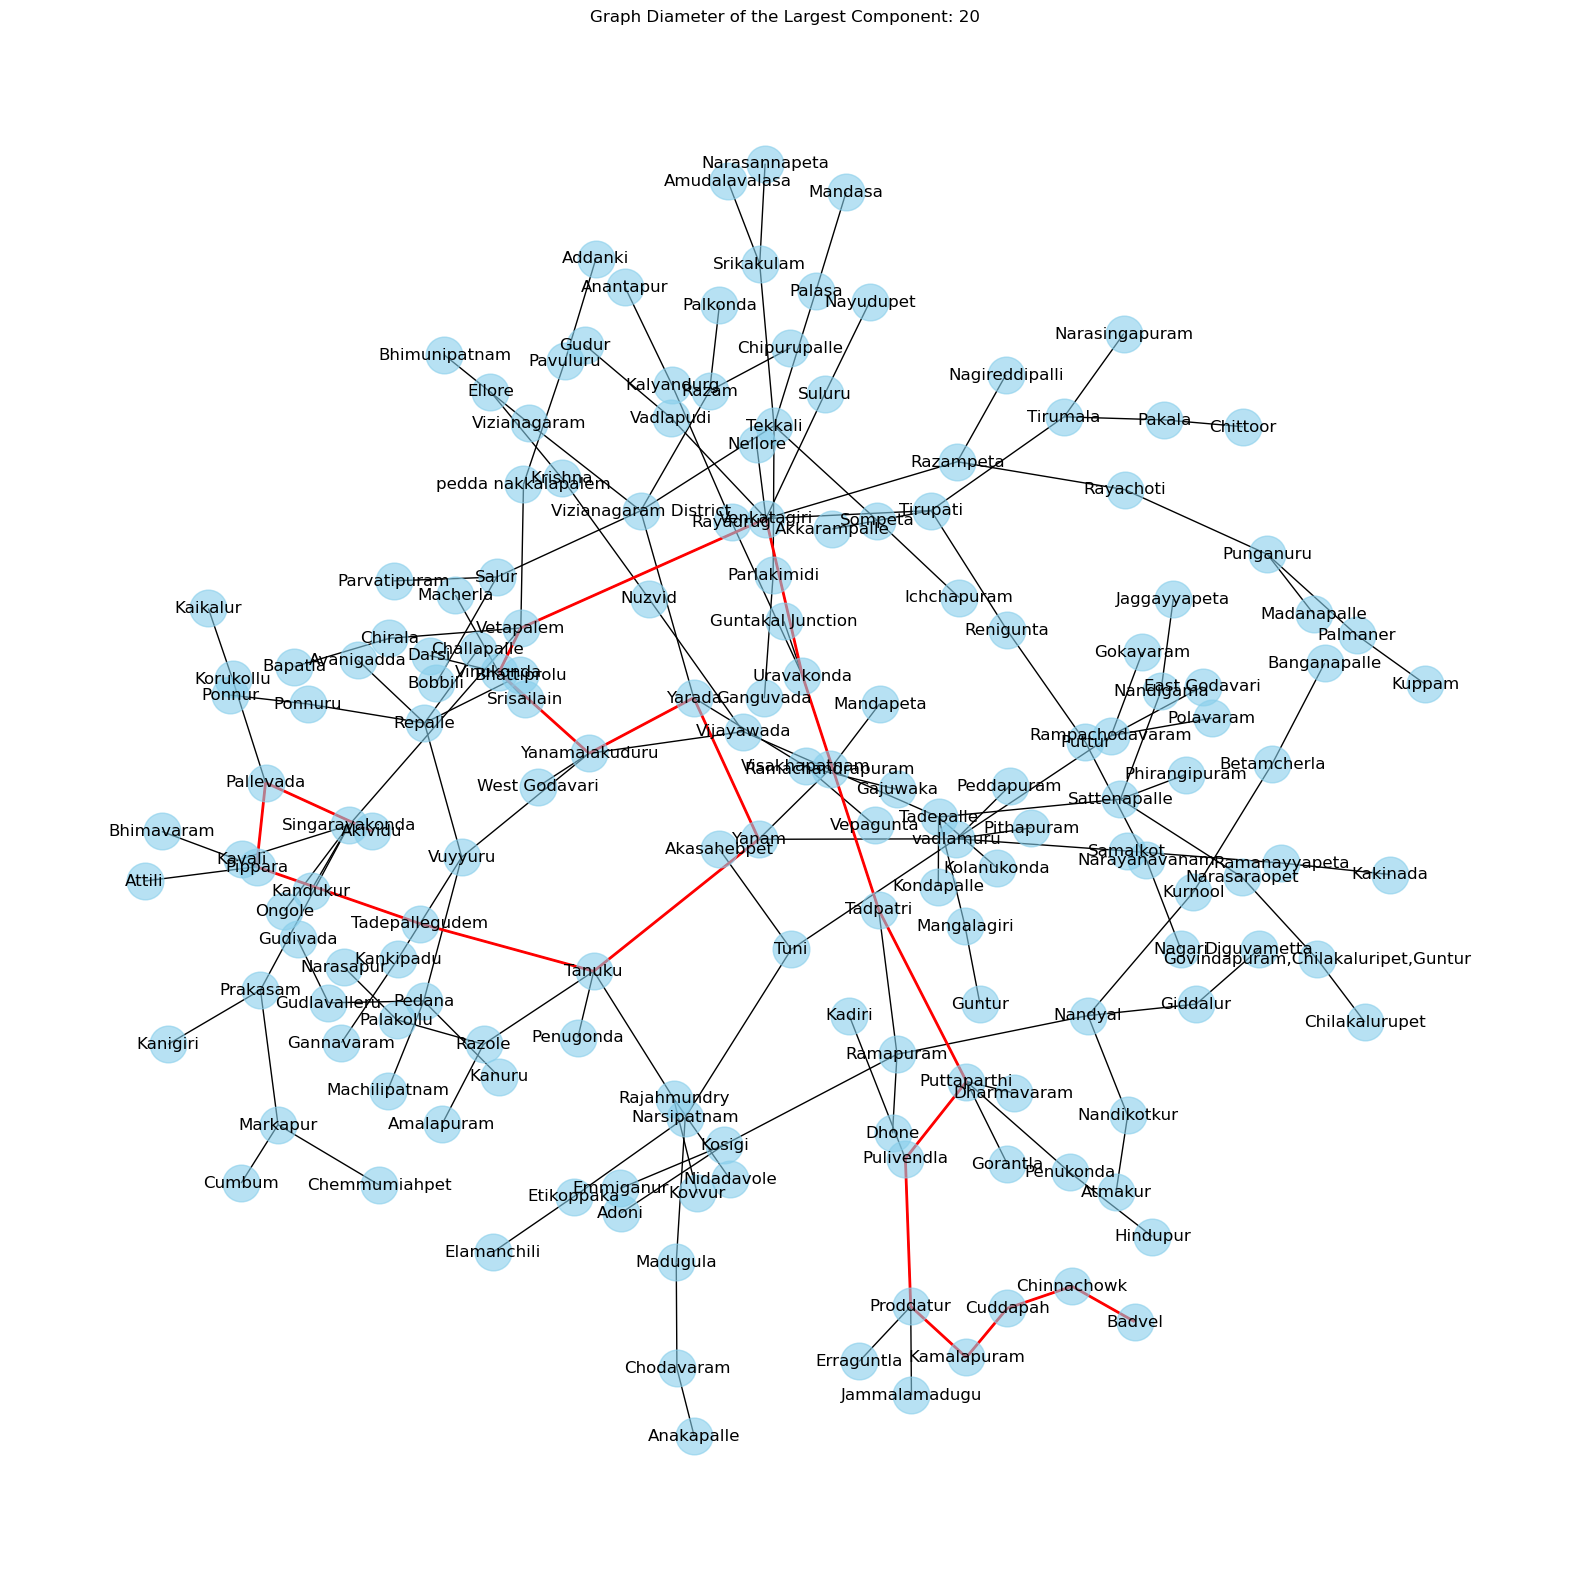

In [98]:
# Find the path with the specified length
longest_path = None
for source, paths in all_pairs_shortest_paths.items():
    for destination, path in paths.items():
        if len(path) == 20:
            longest_path = path
            break
    if longest_path:
        break

# Visualization of the largest connected component with highlighted longest path
plt.figure(figsize=(20, 20))
pos = nx.spring_layout(subgraph, k=0.15, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=700, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(subgraph, pos, width=1)
nx.draw_networkx_labels(subgraph, pos, font_size=12)

# Highlight the longest path
nx.draw_networkx_edges(subgraph, pos, edgelist=[(longest_path[i], longest_path[i+1]) for i in range(len(longest_path)-1)], edge_color='red', width=2)

plt.title(f"Graph Diameter of the Largest Component: {component_diameters[max(component_diameters, key=component_diameters.get)]}")
plt.axis('off')
plt.show()


In [102]:
pip install python-louvain


Note: you may need to restart the kernel to use updated packages.


C:\Users\eswar\AppData\Local\Temp\ipykernel_6004\1280718682.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)


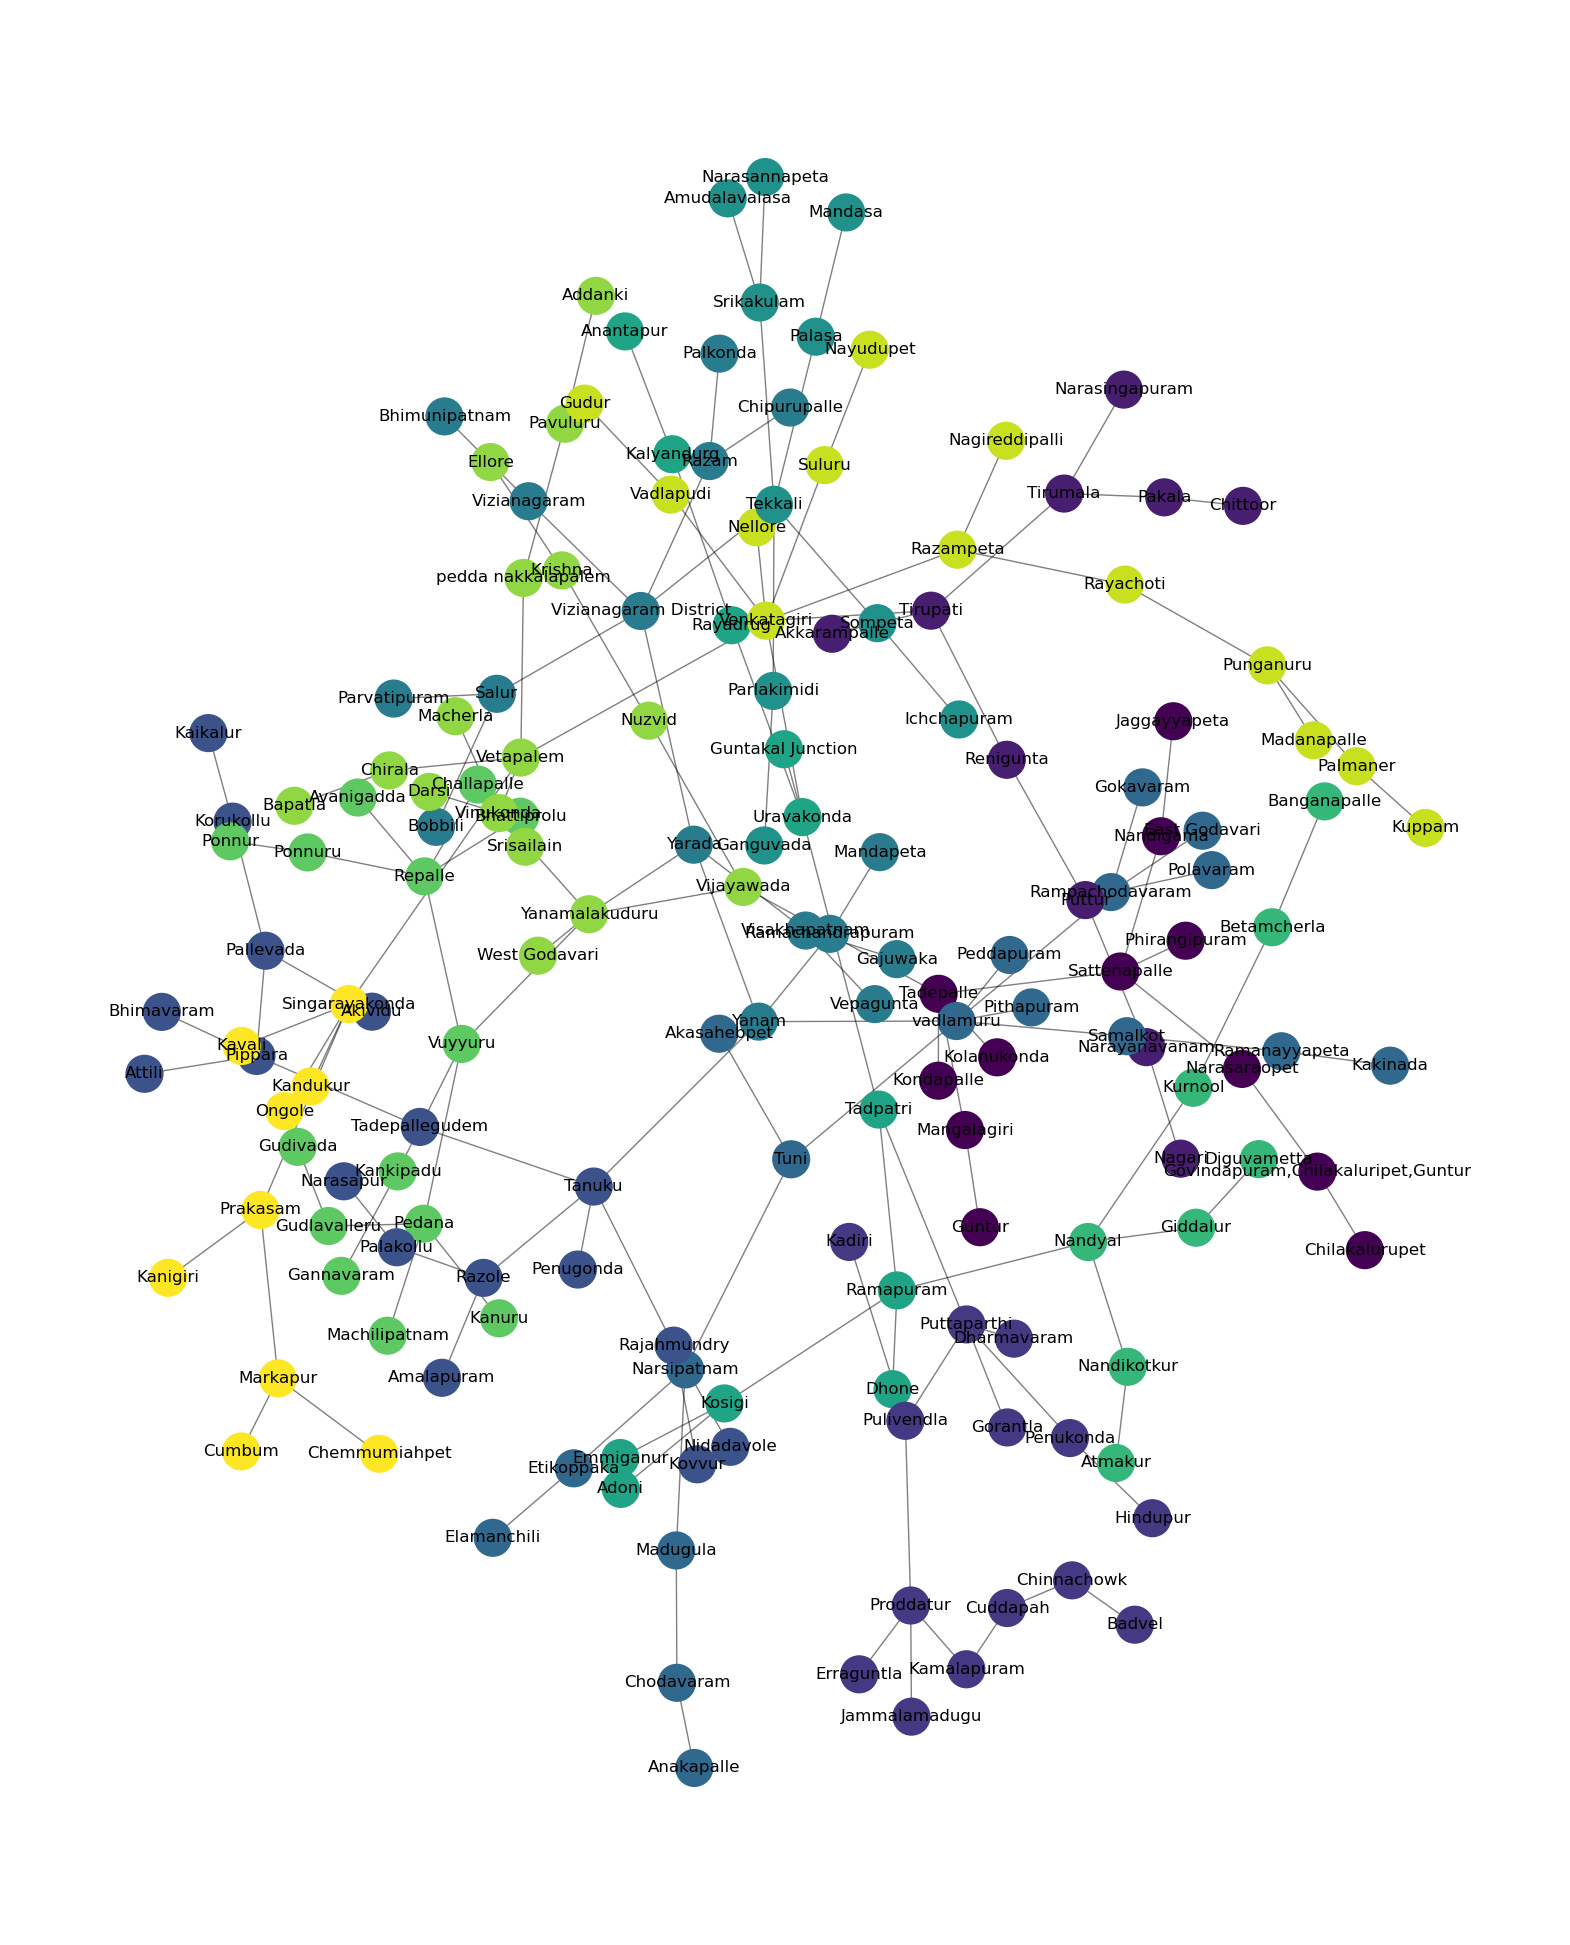

({4: 18, 3: 17, 10: 16, 5: 16, 9: 14},
 {4: ['Akasahebpet',
   'Tuni',
   'Anakapalle',
   'Chodavaram',
   'Madugula',
   'East Godavari',
   'Rampachodavaram',
   'Elamanchili',
   'Etikoppaka',
   'Narsipatnam',
   'Gokavaram',
   'Kakinada',
   'Ramanayyapeta',
   'Peddapuram',
   'vadlamuru',
   'Pithapuram',
   'Polavaram',
   'Samalkot'],
  3: ['Akividu',
   'Pallevada',
   'Amalapuram',
   'Razole',
   'Attili',
   'Pippara',
   'Bhimavaram',
   'Kaikalur',
   'Korukollu',
   'Kovvur',
   'Rajahmundry',
   'Narasapur',
   'Palakollu',
   'Nidadavole',
   'Penugonda',
   'Tanuku',
   'Tadepallegudem'],
  10: ['Addanki',
   'Pavuluru',
   'Bapatla',
   'Chirala',
   'Vetapalem',
   'Darsi',
   'Vinukonda',
   'Ellore',
   'Krishna',
   'Nuzvid',
   'Macherla',
   'Vijayawada',
   'pedda nakkalapalem',
   'Srisailain',
   'Yanamalakuduru',
   'West Godavari'],
  5: ['Bhimunipatnam',
   'Vizianagaram',
   'Bobbili',
   'Salur',
   'Chipurupalle',
   'Razam',
   'Gajuwaka',
   'Visa

In [5]:
# To perform community detection, we will use the Louvain method which is popular for large networks.
# The python-louvain package, which can be installed with 'networkx', implements this method.

import community as community_louvain

# Perform community detection using the Louvain method
partition = community_louvain.best_partition(G)

# Visualization
plt.figure(figsize=(20, 25))
pos = nx.spring_layout(G, k=0.15, seed=42)

# Color the nodes according to their partition
cmap = plt.cm.get_cmap('viridis', max(partition.values()) + 1)
nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=700,
                       cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12)

plt.axis('off')
plt.show()

# Since we want to analyze the result, let's look at the size of each community
communities = {}
for node, comm_id in partition.items():
    communities.setdefault(comm_id, []).append(node)

# Sort communities by size and show the first few
sorted_communities = {k: v for k, v in sorted(communities.items(), key=lambda item: len(item[1]), reverse=True)}

# Show the top communities and their sizes
top_communities = {k: len(v) for k, v in list(sorted_communities.items())[:5]}
top_communities, sorted_communities

Here we divided the cities by grouping them . we grouped the nearest cities all to one community . this helps us to find which city is near and which city is far from one node

In [17]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create dropdowns for source and target cities
city_names = list(G.nodes)
source_dropdown = widgets.Dropdown(options=city_names, description='From:')
target_dropdown = widgets.Dropdown(options=city_names, description='To:')
button = widgets.Button(description='Find Shortest Path')

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        source = source_dropdown.value
        target = target_dropdown.value
        try:
            shortest_path = nx.shortest_path(G, source=source, target=target, weight='Distance')
            path_edges = list(zip(shortest_path, shortest_path[1:]))
            distance_attrs = nx.get_edge_attributes(G, 'Distance (km)')
            
            # Calculate total distance only for edges that have the 'Distance' attribute
            total_distance = sum(distance_attrs[edge] if edge in distance_attrs else distance_attrs[(edge[1], edge[0])] for edge in path_edges if edge in distance_attrs or (edge[1], edge[0]) in distance_attrs)
            
            # Visualization
            plt.figure(figsize=(20, 20))
            pos = nx.spring_layout(G, k=0.15, seed=42)
            
            # Draw all nodes and edges
            nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500, alpha=0.6)
            nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.3)
            nx.draw_networkx_labels(G, pos, font_size=12)
            
            # Draw the shortest path
            nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color='red', node_size=700)
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)
            
            # Draw edge labels (distances)
            edge_labels = {(u, v): f"{d['Distance']} km" for u, v, d in G.edges(data=True) if 'Distance' in d}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
            
            plt.axis('off')
            plt.show()
            
            print(f"Shortest path from {source} to {target}: {shortest_path}")
            print(f"Total distance: {total_distance} km")
        except nx.NetworkXNoPath:
            print("No path found")
        except nx.NodeNotFound:
            print("One of the nodes not found in the graph")

button.on_click(on_button_clicked)

# Display the widgets
display(source_dropdown, target_dropdown, button, output)


Dropdown(description='From:', options=('Addanki', 'Pavuluru', 'Adoni', 'Kosigi', 'Akasahebpet', 'Tuni', 'Akivi…

Dropdown(description='To:', options=('Addanki', 'Pavuluru', 'Adoni', 'Kosigi', 'Akasahebpet', 'Tuni', 'Akividu…

Button(description='Find Shortest Path', style=ButtonStyle())

Output()

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create dropdowns for source and target cities
city_names = list(G.nodes)
source_dropdown = widgets.Dropdown(options=city_names, description='From:')
target_dropdown = widgets.Dropdown(options=city_names, description='To:')
button = widgets.Button(description='Find Shortest Path')

output = widgets.Output()

def on_button_clicked(b):
    with output:
        clear_output()
        source = source_dropdown.value
        target = target_dropdown.value
        try:
            shortest_path = nx.shortest_path(G, source=source, target=target, weight='Distance')
            path_edges = list(zip(shortest_path, shortest_path[1:]))
            distance_attrs = nx.get_edge_attributes(G, 'Distance (km)')
            
            # Calculate total distance only for edges that have the 'Distance' attribute
            total_distance = sum(distance_attrs[edge] if edge in distance_attrs else distance_attrs[(edge[1], edge[0])] for edge in path_edges if edge in distance_attrs or (edge[1], edge[0]) in distance_attrs)
            
            # Visualization
            plt.figure(figsize=(20, 20))
            pos = nx.spring_layout(G, k=0.15, seed=42)
            
            # Draw only the nodes and edges in the shortest path
            nx.draw_networkx_nodes(G, pos, nodelist=shortest_path, node_color='red', node_size=700)
            nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=3)
            nx.draw_networkx_labels(G, pos, labels={node: node for node in shortest_path}, font_size=12)
            
            # Draw edge labels (distances)
            edge_labels = {(u, v): f"{d['Distance']} km" for u, v, d in G.edges(data=True) if 'Distance' in d and ((u, v) in path_edges or (v, u) in path_edges)}
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
            
            plt.axis('off')
            plt.show()
            
            print(f"Shortest path from {source} to {target}: {shortest_path}")
            print(f"Total distance: {total_distance} km")
        except nx.NetworkXNoPath:
            print("No path found")
        except nx.NodeNotFound:
            print("One of the nodes not found in the graph")

button.on_click(on_button_clicked)

# Display the widgets
display(source_dropdown, target_dropdown, button, output)


Dropdown(description='From:', options=('Addanki', 'Pavuluru', 'Adoni', 'Kosigi', 'Akasahebpet', 'Tuni', 'Akivi…

Dropdown(description='To:', options=('Addanki', 'Pavuluru', 'Adoni', 'Kosigi', 'Akasahebpet', 'Tuni', 'Akividu…

Button(description='Find Shortest Path', style=ButtonStyle())

Output()